## Attempt Federated / Decentralized Learning on MNIST
Code modified from official example: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
# Official training implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch, log_interval, dry_run, debug=False):
    model.train()
    loss_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if debug:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break
        loss_history.append(loss.item())
    return loss_history

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)


In [2]:
# Plot methods
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plot_loss_hist(hists, savefig=''):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7))
    fig.suptitle('Top: loss per iteartion; Bottom: avg loss per epoch')
    all_hist = []
    for h in hists:
        all_hist.extend(h)
    avg_hist = [np.mean(h) for h in hists]

    max_num_iteration = len(all_hist)
    num_epoch = len(hists)
    
    ax1.plot(np.arange(max_num_iteration), all_hist)
    ax2.bar(np.arange(num_epoch), avg_hist)
    
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_yscale('log')
    
    ax1.set_ylabel('Loss history')
    ax1.set_ylabel('# of iterations (merged)')
    ax1.set_ylabel('Loss history (average)')
    ax2.set_xlabel('# of epochs')
    
    if len(savefig) > 0:
        plt.savefig('MNIST_DFL_full_dataset_'+savefig+'.jpg')
    

In [3]:
# Parameters for training
batch_size = 64
test_batch_size = 1000
epochs = 14
lr = 1.0
gamma = 0.7
no_cuda = False
dry_run = False
seed = 1
log_interval = 10
save_model = False

use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=False,#True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [4]:
# Main execution for official training
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

loss_history = []
accu_history = []
for epoch in range(1, epochs + 1):
    loss_history.append(
        train(model, device, train_loader, optimizer, epoch, log_interval, dry_run, debug=False)
    )
    print('Finished epoch {0} with loss {1}'.format(epoch, loss_history[-1][-1]))
    test_loss, test_accuracy = test(model, device, test_loader)
    accu_history.append(test_accuracy)
    
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

KeyboardInterrupt: 

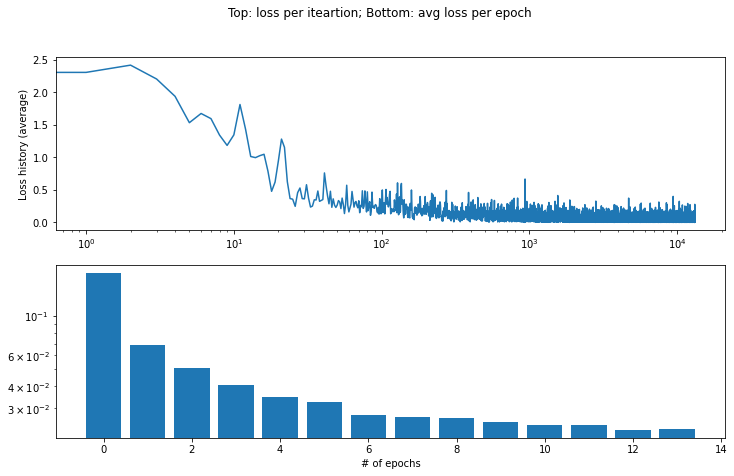

In [18]:
# Plot loss history
plot_loss_hist(loss_history)

In [ ]:
# Print out loss history for future reference
loss_history

In [ ]:
# Plot accuracy history
print(accu_history)
plt.plot(np.arange(len(accu_history)), accu_history)

In [30]:
aaa = 'A'
aaa[0]

'A'

### Standard Federated Learning model (McMahan et al. 2017)
where a central server assigns clients to train, and collects client information to update the average model. 
For this one, assume that each client has access to partitioned data for training. Each local update splits local data into batches, goes through each batch for gradient update, and might repeat for several epochs, depending on how those hyperparameters are set. 

FedAvg. Table 2 contains performance data. For our purpose we don't really care about communication efficiency, so we can start with C\*K=10 (10 clients do update per round, out of 100 clients) with B=10 and E=1. 

In [43]:
import copy
# Implement server logic
class ServerNet():
    def __init__(self):
        self.model = Net().to(device)
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=lr)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)
    
    def update(self, clients):
        # Take averages of each client.
        # https://github.com/AshwinRJ/Federated-Learning-PyTorch/blob/235b8f0ab161825694ee73874295d773b0d3f23f/src/utils.py
        # https://discuss.pytorch.org/t/average-each-weight-of-two-models/77008
        w_avg = copy.deepcopy(clients[0].model.state_dict())
        for key in w_avg.keys():
            for i in range(1, len(clients)):
                w_avg[key] += clients[i].model.state_dict()[key]
            w_avg[key] = torch.div(w_avg[key], len(clients))
        self.model.load_state_dict(w_avg)

# Implement client logic
class ClientNet():
    def __init__(self, dataset, B=16, E=1):
        self.model = Net().to(device)
        self.optimizer = optim.Adadelta(self.model.parameters(), lr=lr)
        self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)
        self.loss_history = []
        self.B = B
        self.E = E
        train_kwargs = {'batch_size': B}
        self.train_loader = torch.utils.data.DataLoader(dataset,**train_kwargs)
        
    def update(self, dry_run=False, max_n=np.inf, weights=None):
        if weights is not None:
            self.model.load_state_dict(weights)
        self.model.train()
        for e in range(self.E):
            self.loss_history.append([])
            # How to only load a limited amount of data?
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                self.optimizer.step()

                self.loss_history[-1].append(loss.item())

#                 if dry_run or batch_idx >= max_n:
                if dry_run or batch_idx * self.B >= max_n:
                    break
        
# Implement train and test logic
def train_FL(server, clients, num_rounds=1, dry_run=False, debug=False, CK=10, max_n=np.inf, test_loader=None):
    server_loss = []
    server_accuracy = []
    for e in range(num_rounds):
        client_inds = np.random.permutation(len(clients))
        chosen_clients = []
        for m in client_inds[:CK]:
            clients[m].update(dry_run, max_n=max_n, weights=server.model.state_dict())
            chosen_clients.append(clients[m])
        server.update(chosen_clients)
        print("round {0} complete".format(e+1))
        # Run the server against test dataset to examine performance
        if test_loader is not None:
            sloss, saccu = test_FL(server, test_loader, debug=False)
            server_loss.append([sloss])
            server_accuracy.append(saccu)
    return server_loss, server_accuracy
    
def test_FL(server, test_loader, debug=True):
    server.model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = server.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if debug:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)


In [108]:
# Define some parameters for FL
K = 20 # Number of clients
C = 0.5 # Fraction of clients updated each round
CK = int(C*K)
B = 10 # Batch size in clients
E = 1 # Epochs per client update
n = len(dataset1) # Number of training samples in total
num_rounds = 100
max_n = n/num_rounds/CK
nk = [int(n/K)]*K
nk[-1] = n - np.sum(nk[:-1])

# Create agents and assign data to each agent
partitioned_dataset = torch.utils.data.random_split(dataset1, nk)

# Create agents
clients = []
for i in range(K):
    clients.append(ClientNet(dataset1, B, E))
#     clients.append(ClientNet(partitioned_dataset[i], B, E))
server = ServerNet()

server_loss_history, server_accuracy_history = train_FL(server, clients, num_rounds=num_rounds, dry_run=False, CK=CK, max_n=max_n, 
                               test_loader=test_loader)
test_FL(server, test_loader)
    
# test_kwargs = {'batch_size': test_batch_size}
# train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
# test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

round 1 complete
round 2 complete
round 3 complete
round 4 complete
round 5 complete
round 6 complete
round 7 complete
round 8 complete
round 9 complete
round 10 complete
round 11 complete
round 12 complete
round 13 complete
round 14 complete
round 15 complete
round 16 complete
round 17 complete
round 18 complete
round 19 complete
round 20 complete
round 21 complete
round 22 complete
round 23 complete
round 24 complete
round 25 complete
round 26 complete
round 27 complete
round 28 complete
round 29 complete
round 30 complete
round 31 complete
round 32 complete
round 33 complete
round 34 complete
round 35 complete
round 36 complete
round 37 complete
round 38 complete
round 39 complete
round 40 complete
round 41 complete
round 42 complete
round 43 complete
round 44 complete
round 45 complete
round 46 complete
round 47 complete
round 48 complete
round 49 complete
round 50 complete
round 51 complete
round 52 complete
round 53 complete
round 54 complete
round 55 complete
round 56 complete
r

(0.0689231725692749, 98.62)

In [42]:
sum([0,1,2])

3

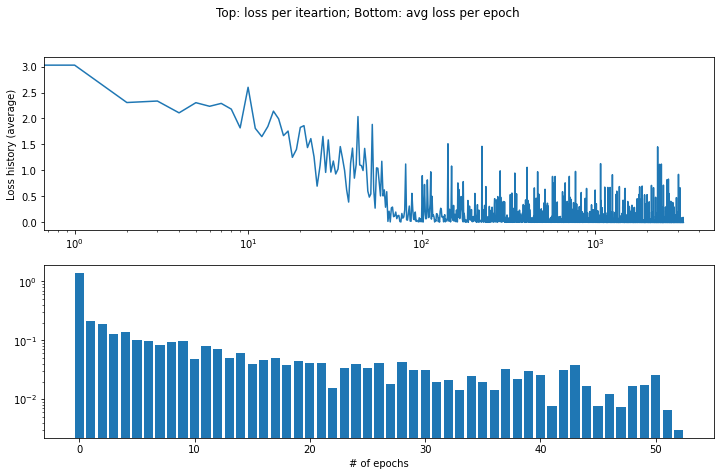

In [109]:
# Visualize loss history of some nets
plot_loss_hist(clients[1].loss_history)

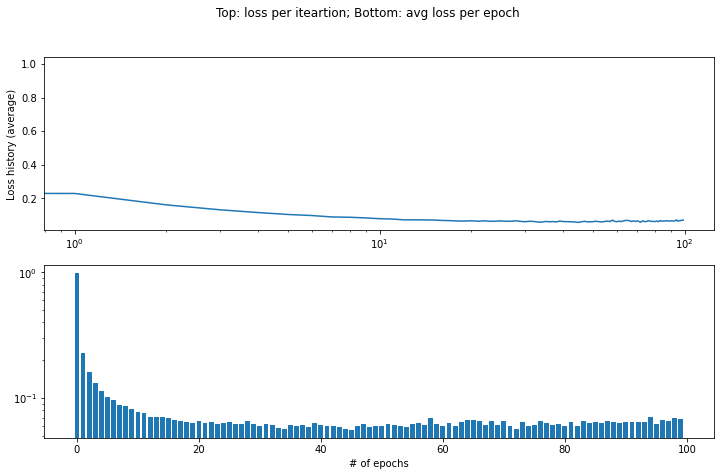

In [110]:
plot_loss_hist(server_loss_history)

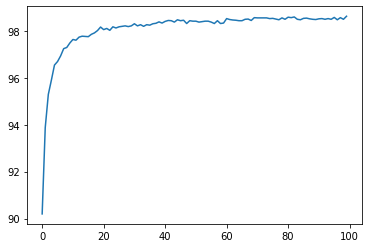

In [111]:
plt.plot(np.arange(len(server_accuracy_history)), server_accuracy_history)

In [ ]:
# Explore what happens when there's more clients and less data for each client
K = 100 # Number of clients
C = 0.1 # Fraction of clients updated each round
CK = int(C*K)
B = 64 # Batch size in clients
E = 1 # Epochs per client update
n = len(dataset1) # Number of training samples in total
num_rounds = 100
max_n = n/K
nk = [int(n/K)]*K
nk[-1] = n - np.sum(nk[:-1])

# Create agents and assign data to each agent
partitioned_dataset = torch.utils.data.random_split(dataset1, nk)

# Create agents
clients = []
for i in range(K):
#     clients.append(ClientNet(dataset1, B, E))
    clients.append(ClientNet(partitioned_dataset[i], B, E))
server = ServerNet()

server_loss_history, server_accuracy_history = train_FL(server, clients, num_rounds=num_rounds, dry_run=False, CK=CK, max_n=max_n, 
                               test_loader=test_loader)
test_FL(server, test_loader)

In [90]:
kkkks = clients_DFL[0].model.state_dict().keys()

In [107]:
for i,k in enumerate(kkkks):
    print(clients_DFL[0].model.state_dict()[k].shape, i)

torch.Size([32, 1, 3, 3]) 0
torch.Size([32]) 1
torch.Size([64, 32, 3, 3]) 2
torch.Size([64]) 3
torch.Size([128, 9216]) 4
torch.Size([128]) 5
torch.Size([10, 128]) 6
torch.Size([10]) 7


In [96]:
np.sum(np.ones((3,4)),axis=0)

array([3., 3., 3., 3.])

In [104]:
testtt = np.array([[1,2,3],[0,1,2],[1,0,0]])
# testtt[testtt!=0]=1
# testtt
np.nonzero(testtt[1,:])

(array([1, 2]),)

In [114]:
int(np.nonzero(testtt[1,:])[0])

TypeError: only size-1 arrays can be converted to Python scalars

In [105]:
np.ones((0,))

array([], dtype=float64)

### Decentralized Federated Learning
First off, let's see what happens when there's no centralized server to control the progress. Suppose all we have is a complete graph of connections, and instead of averaging on the server side, the averaging takes place in every agent after finishing local updates with the same B and E. 

Optionally, we can assign weights to each edge according to performance, but that might again require centralized control. This might help establish who's the leader at each update.

For now, let's give each agent full access to the training data, just to get an idea.

In [46]:
# Try to see if you can train distributedly - i.e. average between several separate models
# Implement train and test logic. This one doens't have a server, and I assume we can let them all update together.
def train_DFL(adj, clients, num_rounds=1, dry_run=False, debug=False, CK=10, max_n=np.inf, test_loader=None,
              avg_weight=1, test_all_client=False,
              num_avg_iter=-1, max_num_avg_iter=1000, avg_error_thres=0.01):
    test_loss = []
    test_accuracy = []
    for e in range(num_rounds):
        # Update each client
        for m in clients:
            m.update(dry_run, max_n=max_n)
        # Aggregation for each client. How it's done depends on the num_avg_iter argument:
        # num_avg_iter > 0: Execute at most this number of consensus averaging.
        # num_avg_iter < 0: Execute until the system reaches consensus (with pairwise errors smaller than avg_error_thres)
           
        reached_consensus = False
#         print(clients[0].model.state_dict()['fc2.bias'])
        for k in range(max_num_avg_iter):
            if reached_consensus:
                break
            if (k > num_avg_iter and num_avg_iter > 0):
                break
            
            # Set up variables where we do the averaging calculation without disturbing the previous weights
            new_models = []
            for i in range(len(clients)):
                new_models.append( copy.deepcopy(clients[i].model.state_dict()) )

            reached_consensus = True
            # Start averaging towards the goal. Here we use equal neighbor averaging method.
            for i in range(len(clients)):
                for j in range(len(clients)):
                    # Record each key's value, while also keeping track of distance
                    client_wise_dist = 0
                    for key in new_models[j].keys():
                        if reached_consensus and j>i: # Avoid double checking
                            client_wise_dist += np.linalg.norm( clients[j].model.state_dict()[key] - clients[i].model.state_dict()[key] )
                        new_models[i][key] += avg_weight * adj[i,j] * clients[j].model.state_dict()[key]
                    if client_wise_dist > avg_error_thres and reached_consensus and j>i:
#                         print('Clients {} and {} showed theres no convergence yet'.format(i,j))
                        reached_consensus = False
#                     if i==0:
#                         print(k, clients[0].model.state_dict()['fc2.bias'])
            if reached_consensus:
                break
            
            # Process the recorded values
            for i in range(len(clients)):
                Ni = np.sum(adj[i,:])
                for key in new_models[i].keys():
                    new_models[i][key] -= clients[i].model.state_dict()[key]
                    new_models[i][key] /= Ni # Or use torch.div()
#                 print(i, Ni, new_models[i]['fc2.bias'])

            # Load averaged results
            for i in range(len(clients)):
                clients[i].model.load_state_dict(new_models[i])
#         print("round {0} complete with {1} averaging steps".format(e+1,k))
        
        # Run the client with lowest loss against test dataset to examine performance
        if test_loader is not None:
            if test_all_client:
                test_loss.append([])
                saccus = []
                # Let all clients go over the test, and take the max accuracy as this round's accuracy
                for c in clients:
                    sloss, saccu = test_DFL([c], test_loader, debug=False)
                    test_loss[-1].append(sloss)
                    saccus.append(saccu)
                test_accuracy.append(np.max(saccu))
            else:
                # Only record the best client's performance
                sloss, saccu = test_DFL(clients, test_loader, debug=False)
                test_loss.append([sloss])
                test_accuracy.append(saccu)
        print("round {0} complete with {1} averaging steps and test accuracy {2}".format(e+1,k,test_accuracy[-1]))
    return test_loss, test_accuracy
    
def test_DFL(clients, test_loader, debug=True):
    # Pick the client with the lowest loss to run against test dataset
    losses = []
    for c in clients:
        c.model.eval()
        losses.append(np.mean(c.loss_history[-1]))
    ind = np.argmin(losses)
    server = clients[ind]

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = server.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if debug:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)


In [56]:
# Define some parameters for DFL
K = 10 # Number of clients
B = 64#10 # Batch size in clients
C = 1
E = 1 # Epochs per client update
n = len(dataset1) # Number of training samples in total
num_rounds = 5#200
EE = 1/20 # (1/num_rounds) # Portion of data per epoch (<= 1)
max_n = n*EE #/K #* (1/num_rounds)

# Create adjacency matrix
AK = np.zeros((K,K))
# For a complete graph:
AK = np.ones((K,K))
for i in range(K):
    AK[i,i] = 0
torch.manual_seed(1)
# Create agents
clients_DFL = []
for i in range(K):
    clients_DFL.append(ClientNet(dataset1, B, E))

# Optional: Set all clients to the same initial weights
for i in range(1,K):
    clients_DFL[i].model.load_state_dict( clients_DFL[0].model.state_dict() )
    
DFL_loss_history, DFL_accuracy_history = train_DFL(AK, clients_DFL, num_rounds=num_rounds, dry_run=True,#False, 
                                                   CK=K, max_n=max_n, 
                             test_loader=test_loader, test_all_client=True,
              num_avg_iter=-1, max_num_avg_iter=100, avg_error_thres=0.01)
test_DFL(clients_DFL, test_loader)

round 1 complete with 3 averaging steps and test accuracy 18.8
round 2 complete with 3 averaging steps and test accuracy 41.25
round 3 complete with 3 averaging steps and test accuracy 53.4
round 4 complete with 3 averaging steps and test accuracy 46.88
round 5 complete with 3 averaging steps and test accuracy 18.02

Test set: Average loss: 2.2943, Accuracy: 1802/10000 (18%)



(2.29430166015625, 18.02)

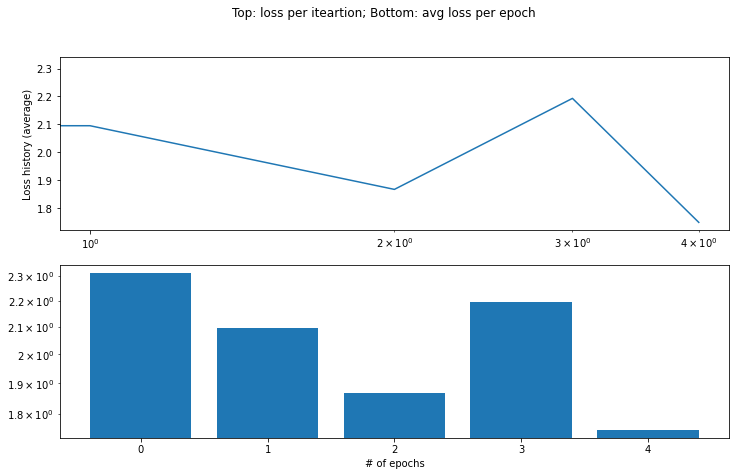

In [53]:
plot_loss_hist(clients_DFL[1].loss_history)

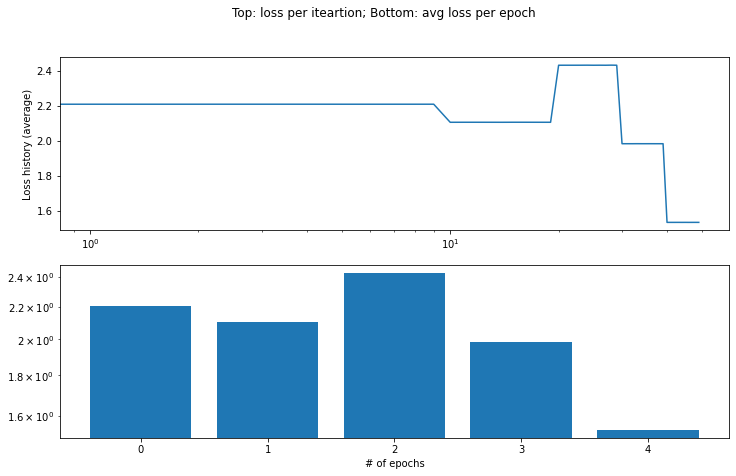

In [54]:
plot_loss_hist(DFL_loss_history)

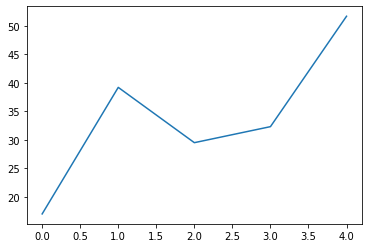

In [55]:
plt.plot(np.arange(len(DFL_accuracy_history)), DFL_accuracy_history)

In [18]:
np.save('testtt', DFL_loss_history)


In [20]:
testtt = np.load('testtt.npy')
plt.plot(np.arange(len(testtt)), testtt)

In [41]:
clients_DFL[1].model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-4.0021e-03,  9.4304e-02,  4.4953e-02],
                        [-3.1862e-02, -1.4976e-01,  6.4353e-02],
                        [-3.3937e-02,  3.8324e-02,  4.6799e-02]]],
              
              
                      [[[-6.4097e-02,  8.9263e-02,  7.8974e-02],
                        [ 1.7895e-02, -7.1332e-02, -8.9274e-03],
                        [-7.1689e-02,  3.5507e-02, -6.3348e-02]]],
              
              
                      [[[ 2.7150e-03,  6.4183e-02,  2.6465e-02],
                        [-6.3940e-02, -4.4179e-02, -6.0921e-02],
                        [ 1.1432e-02,  5.6533e-02,  3.9350e-02]]],
              
              
                      [[[-3.3926e-02, -2.4614e-03,  8.2899e-02],
                        [ 4.3083e-02, -7.7422e-02,  7.4511e-03],
                        [ 2.6368e-02,  3.3437e-02, -5.4512e-02]]],
              
              
                      [[[-1.9048e-02, -6.2342e-03,  5.6881e-02

### Decentralized FL with sparser connections
This time, reduce the connectivity graph to a cycle, for example, or a line. Still give each agent full data access. You should see slower convergence to consensus, but the effect to each agent's performance history would be interesting to see. 

However, if the procedure is to get to convergence before the next round starts, then the topology won't matter when network is always B-strongly connected. 

In [64]:
# Using a cycle adj matrix
AC = np.zeros((K,K))
AC[0,-1] = 1
AC[-1,0] = 1
for i in range(K-1):
    AC[i,i+1] = 1
    AC[i+1,i] = 1
# Create agents
clients_DFL_cyc = []
for i in range(K):
    clients_DFL_cyc.append(ClientNet(dataset1, B, E))

DFL_cyc_loss_history, DFL_cyc_accuracy_history = train_DFL(AK, clients_DFL_cyc, num_rounds=num_rounds, dry_run=True, CK=CK, max_n=max_n, 
                             test_loader=test_loader, test_all_client=True,
              num_avg_iter=-1, max_num_avg_iter=100, avg_error_thres=0.01)
test_DFL(clients_DFL_cyc, test_loader)

round 1 complete
round 2 complete
round 3 complete
round 4 complete
round 5 complete
round 6 complete
round 7 complete
round 8 complete
round 9 complete
round 10 complete
round 11 complete
round 12 complete
round 13 complete
round 14 complete
round 15 complete
round 16 complete
round 17 complete
round 18 complete
round 19 complete
round 20 complete
round 21 complete
round 22 complete
round 23 complete
round 24 complete
round 25 complete
round 26 complete
round 27 complete
round 28 complete
round 29 complete
round 30 complete
round 31 complete
round 32 complete
round 33 complete
round 34 complete
round 35 complete
round 36 complete
round 37 complete
round 38 complete
round 39 complete
round 40 complete
round 41 complete
round 42 complete
round 43 complete
round 44 complete
round 45 complete
round 46 complete
round 47 complete
round 48 complete
round 49 complete
round 50 complete
round 51 complete
round 52 complete
round 53 complete
round 54 complete
round 55 complete
round 56 complete
r

2.235593153029318e+17

In [61]:
import pickle
with open("Testpickle", "wb") as fp:
    pickle.dump([DFL_loss_history, DFL_accuracy_history,clients_DFL], fp)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [62]:
with open("Testpickle", "rb") as fp:
    testreadvar = pickle.load(fp)

In [66]:
testreadvar[-1][0].B

64

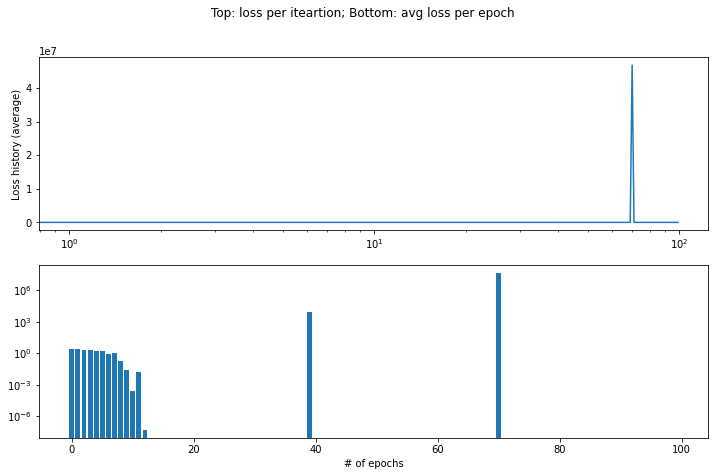

In [87]:
plot_loss_hist(clients_DFL_cyc[1].loss_history)

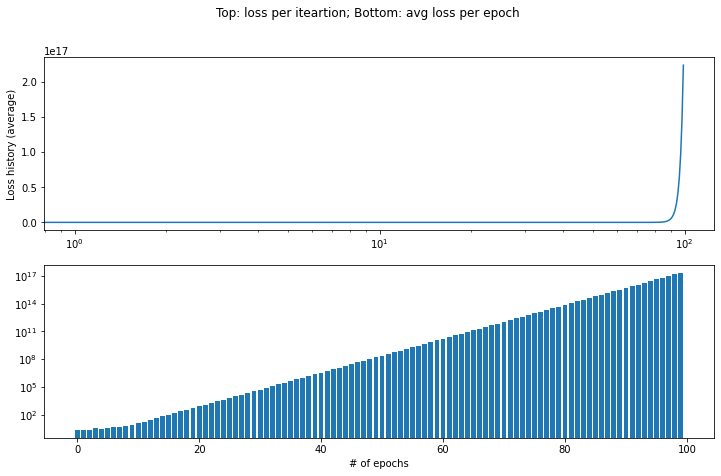

In [76]:
plot_loss_hist(DFL_cyc_loss_history)

In [ ]:
plt.plot(np.arange(len(DFL_cyc_accuracy_history)), DFL_cyc_accuracy_history)

### Decentralized FL with localized data - maybe not even IID
The only difference from the above 2 is that this one partitions training data, so that each partition is only accessible by one single agent during the entire training. The network topology would be 

In [114]:
# Divide up the dataset into partitions. Start from uniform partition first. 
K = 15 # Number of clients
B = 32 # Batch size in clients
E = 1 # Epochs per client update
n = len(dataset1) # Number of training samples in total
num_rounds = 100
max_n = n/num_rounds
# Decide how many samples to assign for each client network
nk = [int(n/K)]*K
nk[-1] = n - np.sum(nk[:-1])
# nkc = [0] + np.cumsum(nk)

# Create adjacency matrix
AK = np.zeros((K,K))
# For a complete graph:
AK = np.ones((K,K))
for i in range(K):
    AK[i,i] = 0

# Create agents and assign data to each agent
partitioned_dataset = torch.utils.data.random_split(dataset1, nk)
clients_DFL_Part = []
for i in range(K):
    clients_DFL_Part.append(ClientNet(partitioned_dataset[i], B, E))

DFL_Part_loss_history, DFL_Part_accuracy_history = train_DFL(
    AK, clients_DFL_Part, num_rounds=num_rounds, dry_run=False, CK=CK, max_n=max_n, 
    test_loader=test_loader, avg_weight=0.9)
test_DFL(clients_DFL_Part, test_loader)

round 1 complete
round 2 complete
round 3 complete
round 4 complete
round 5 complete
round 6 complete
round 7 complete
round 8 complete
round 9 complete
round 10 complete
round 11 complete
round 12 complete
round 13 complete
round 14 complete
round 15 complete
round 16 complete
round 17 complete
round 18 complete
round 19 complete
round 20 complete
round 21 complete
round 22 complete
round 23 complete
round 24 complete
round 25 complete
round 26 complete
round 27 complete
round 28 complete
round 29 complete
round 30 complete
round 31 complete
round 32 complete
round 33 complete
round 34 complete
round 35 complete
round 36 complete
round 37 complete
round 38 complete
round 39 complete
round 40 complete
round 41 complete
round 42 complete
round 43 complete
round 44 complete
round 45 complete
round 46 complete
round 47 complete
round 48 complete
round 49 complete
round 50 complete
round 51 complete
round 52 complete
round 53 complete
round 54 complete
round 55 complete
round 56 complete
r

(nan, 9.8)

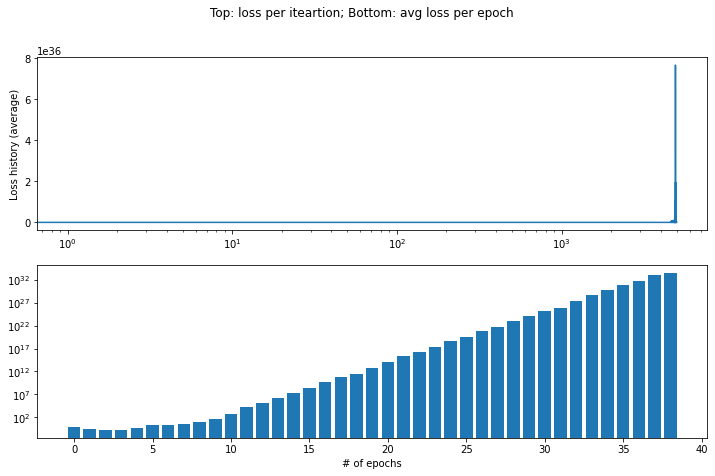

In [119]:
plot_loss_hist(clients_DFL_Part[10].loss_history)

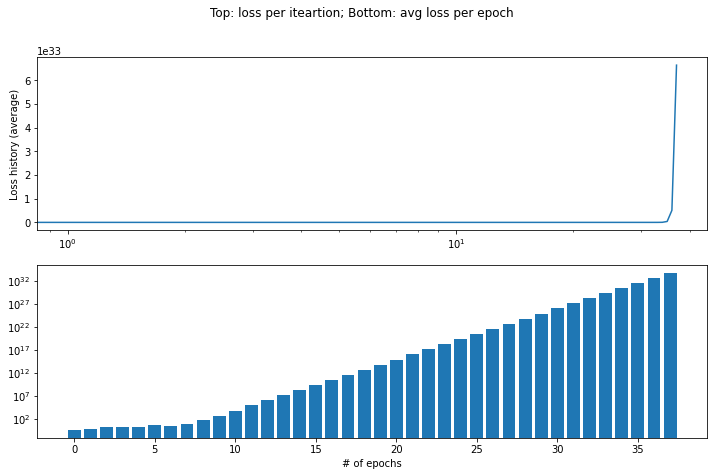

In [116]:
plot_loss_hist(DFL_Part_loss_history)

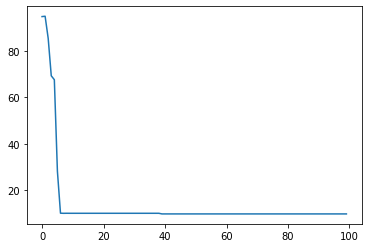

In [117]:
plt.plot(np.arange(len(DFL_Part_accuracy_history)), DFL_Part_accuracy_history)

In [80]:
len(dataset1)

60000

### Decentralized but not Federated?
There are other methods such as GADMM that use parallellism in learning. You can try them out if you know how to write them out. 